# Forecasting Energy Consumption Per Town with Prophet

In [230]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.serialize import model_to_json
import matplotlib.pyplot as plt
from pathlib import Path
import json

In [ ]:
df = pd.read_parquet('./Data/combined_dataset.parquet')
df = df.fillna(0)  # Clean any missing data
df = df.sort_values('timestamp')  # Ensure time order
df.head()

,timestamp,energy_kWh_a,energy_kWh_b,energy_kWh_c,total_energy_kWh,Month,Year,Date,Time,Week,...,backup_voltage_phase_a,backup_voltage_phase_b,backup_voltage_phase_c,meter_voltage_phase_a,meter_voltage_phase_b,meter_voltage_phase_c,Location,Town,heatpump_pct,rolling_avg
0,2024-10-10 10:00:00+00:00,0.077103,0.043197,0.051531,0.171832,10.0,2024.0,2024-10-10,10:00:00,41,...,231.9,233.9,229.6,232.8,232.9,229.9,Tregattu 11,Siljansnäs,0.033959,0.0
1,2024-10-10 10:00:00+00:00,0.077103,0.043197,0.051531,0.171832,10.0,2024.0,2024-10-10,10:00:00,41,...,241.2,238.2,239.4,239.9,241.0,241.5,Tregattu 11,Siljansnäs,0.108754,0.0
2,2024-10-10 10:00:00+00:00,0.077103,0.043197,0.051531,0.171832,10.0,2024.0,2024-10-10,10:00:00,41,...,234.6,232.5,233.1,233.8,233.3,232.8,Tregattu 11,Siljansnäs,0.040054,0.0
3,2024-10-10 11:00:00+00:00,0.135067,0.080545,0.096872,0.312484,10.0,2024.0,2024-10-10,11:00:00,41,...,231.2,233.9,232.4,230.8,234.0,233.3,Tregattu 11,Siljansnäs,0.067346,0.0
4,2024-10-10 11:00:00+00:00,0.135067,0.080545,0.096872,0.312484,10.0,2024.0,2024-10-10,11:00:00,41,...,241.5,240.4,239.8,242.1,240.7,241.1,Tregattu 11,Siljansnäs,0.120186,0.0


## Preprocessing & Feature Engineering

In [232]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df.dropna(subset=['total_energy_kWh', 'Town'], inplace=True)

# Aggregate Monthly Energy Use Per Town

In [233]:
monthly_grouped = (
    df.groupby(['Town', pd.Grouper(key='Date', freq='ME')])
    .agg({'total_energy_kWh': 'sum', 'Month': 'first', 'Month_sin': 'first', 'Month_cos': 'first'})
    .reset_index()
)

monthly_grouped.rename(columns={'Date': 'ds', 'total_energy_kWh': 'y'}, inplace=True)
monthly_grouped.head()

,Town,ds,y,Month,Month_sin,Month_cos
0,Bettna,2025-01-31,2870.482112,1,0.500000,8.660254e-01
1,Bettna,2025-02-28,13356.670407,2,0.866025,5.000000e-01
2,Bettna,2025-03-31,17162.718785,3,1.000000,6.123234e-17
3,Bettna,2025-04-30,707.000920,4,0.866025,-5.000000e-01
4,Bro,2025-01-31,1559.271401,1,0.500000,8.660254e-01


# Define Forecasting Function Using Prophet

In [234]:
def train_and_forecast_Town(df, Town_name, periods=12):
    """
    Trains a Prophet model on historical energy consumption data for a specific Town
    and generates a 12-month forecast, enhanced by cyclic time features.
    
    Parameters:
    ----------
    df : pd.DataFrame
        The input DataFrame with at least the following columns:
        - 'ds' : datetime64 — Timestamp for each observation (monthly)
        - 'y' : float — Observed energy consumption (kWh)
        - 'Month_sin', 'Month_cos' : float — Cyclical month encodings
        - 'Town' : str — Geographic label to subset on
    
    Town_name : str
        The name of the Town to generate a forecast for.

    periods : int
        Number of future periods (months) to forecast.

    Returns:
    -------
    forecast_df : pd.DataFrame
        A DataFrame containing the forecast results with renamed, descriptive columns:
        - 'Date_Stamp': datetime — Forecast date
        - 'Forecast_kWh': float — Predicted energy consumption (kWh)
        - 'Forecast_Lower_Bound': float — Lower bound of prediction interval
        - 'Forecast_Upper_Bound': float — Upper bound of prediction interval
    """

    # Subset the data for the target Town
    df_Town = df[df['Town'] == Town_name].copy()

    # Initialize Prophet and add seasonal regressors
    model = Prophet(yearly_seasonality=True)
    model.add_regressor('Month_sin')
    model.add_regressor('Month_cos')

    # Train the model on the historical data
    model.fit(df_Town[['ds', 'y', 'Month_sin', 'Month_cos']])

    # Create future DataFrame for prediction
    future = model.make_future_dataframe(periods=periods, freq='ME')
    last_month = df_Town['Month'].iloc[-1]

    # Add cyclic time encodings to future DataFrame
    future['Month'] = ((last_month + np.arange(1, periods + 1 + len(df_Town))) % 12) + 1
    future['Month_sin'] = np.sin(2 * np.pi * future['Month'] / 12)
    future['Month_cos'] = np.cos(2 * np.pi * future['Month'] / 12)

    # Generate forecast
    forecast = model.predict(future)

    # Plot the forecast (without showing black historical dots)
    fig = model.plot(forecast)
    plt.xlabel("Date (Month)", fontsize=12)
    plt.ylabel("Total Energy Consumption (kWh)", fontsize=12)
    plt.title(f"Energy Consumption Forecast for {Town_name}", fontsize=14)

    # Remove historical data dots (black markers) from the plot
    for line in fig.gca().get_lines():
        line.set_alpha(0.0)  # Fully transparent
    
    plt.show()

    # Save the model
    Path("prophet_models").mkdir(exist_ok=True)
    with open(f'prophet_models/{Town_name}.json', 'w') as fout:
        json.dump(model_to_json(model), fout)

    # Rename columns and attach Town
    forecast_df = forecast.rename(columns={
        'ds': 'Date_Stamp',  # Datestamp: Time index for forecasts
        'yhat': 'Forecast_kWh',  # Predicted value (forecast)
        'yhat_lower': 'Forecast_Lower_Bound',  # Lower bound of confidence interval
        'yhat_upper': 'Forecast_Upper_Bound'   # Upper bound of confidence interval
    })[['Date_Stamp', 'Forecast_kWh', 'Forecast_Lower_Bound', 'Forecast_Upper_Bound']]
    
    forecast_df['Town'] = Town_name  # Tag with Town

    # Save to CSV with Town-specific naming
    Path("prophet_forecasts").mkdir(exist_ok=True)
    csv_path = f'prophet_forecasts/{Town_name}_forecast.csv'
    forecast_df.to_csv(csv_path, index=False)

    return forecast_df

# Run Forecast for All Towns and Export Results

15:11:19 - cmdstanpy - INFO - Chain [1] start processing



Forecasting: Bettna


15:11:19 - cmdstanpy - INFO - Chain [1] done processing


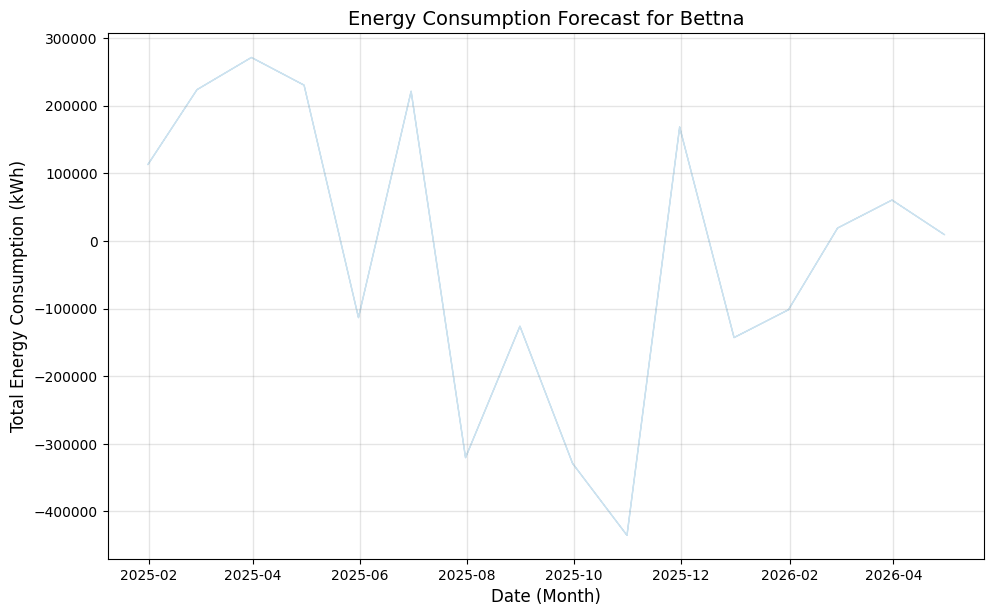

15:11:20 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Bro


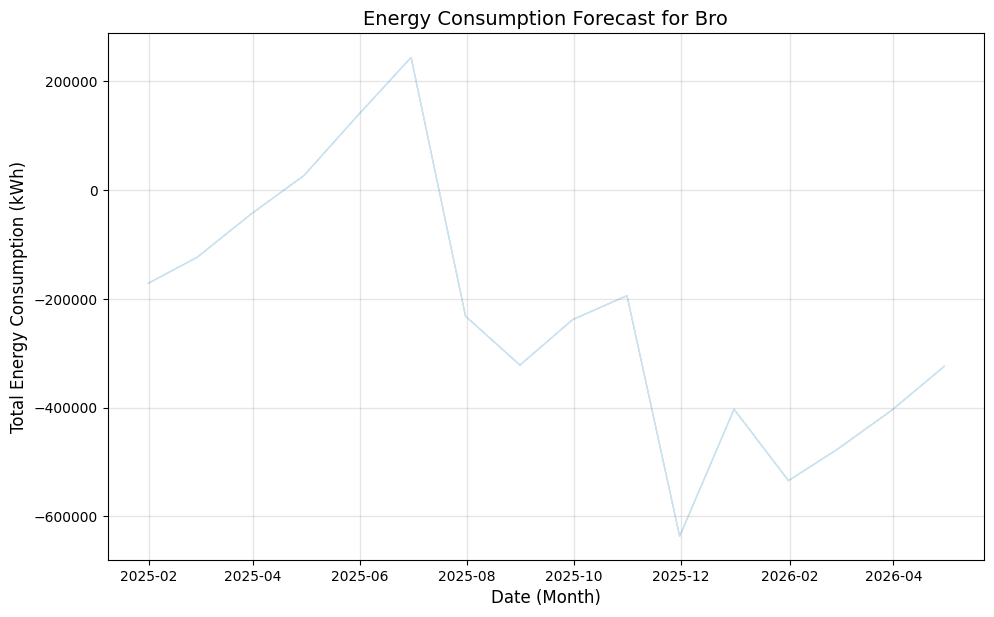

15:11:20 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Bälinge


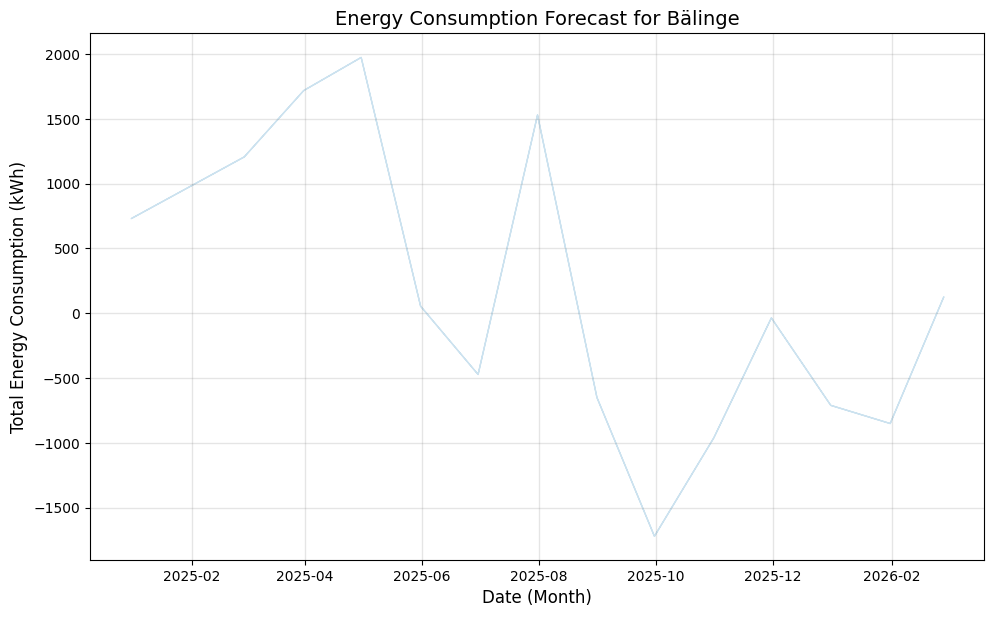

15:11:20 - cmdstanpy - INFO - Chain [1] start processing
15:11:20 - cmdstanpy - INFO - Chain [1] done processing


Skipping Degerfors due to insufficient data (1 rows).

Forecasting: Djursholm


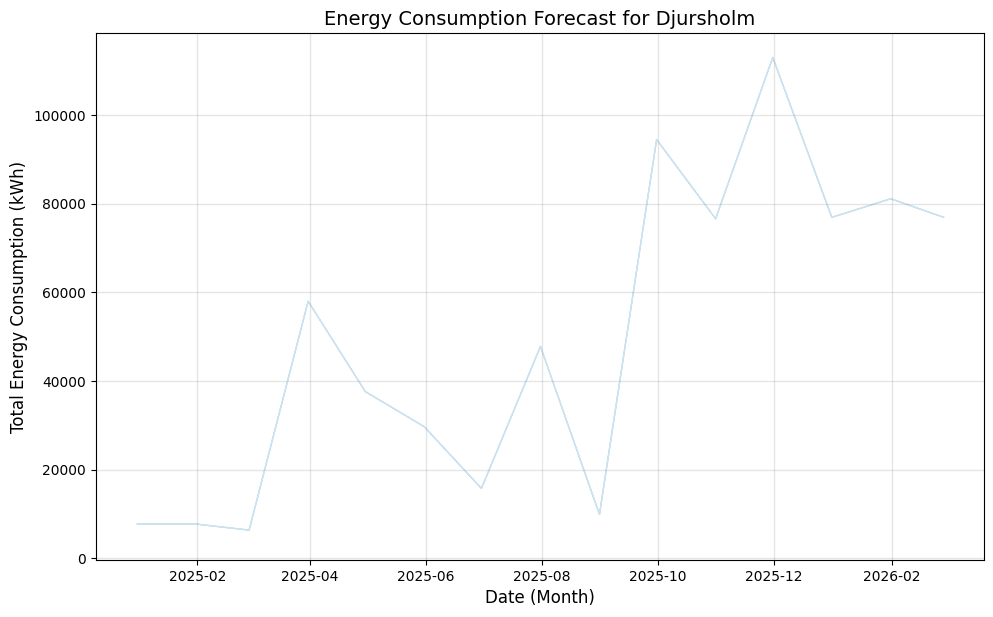

15:11:20 - cmdstanpy - INFO - Chain [1] start processing



Forecasting: Fagersta


15:11:21 - cmdstanpy - INFO - Chain [1] done processing


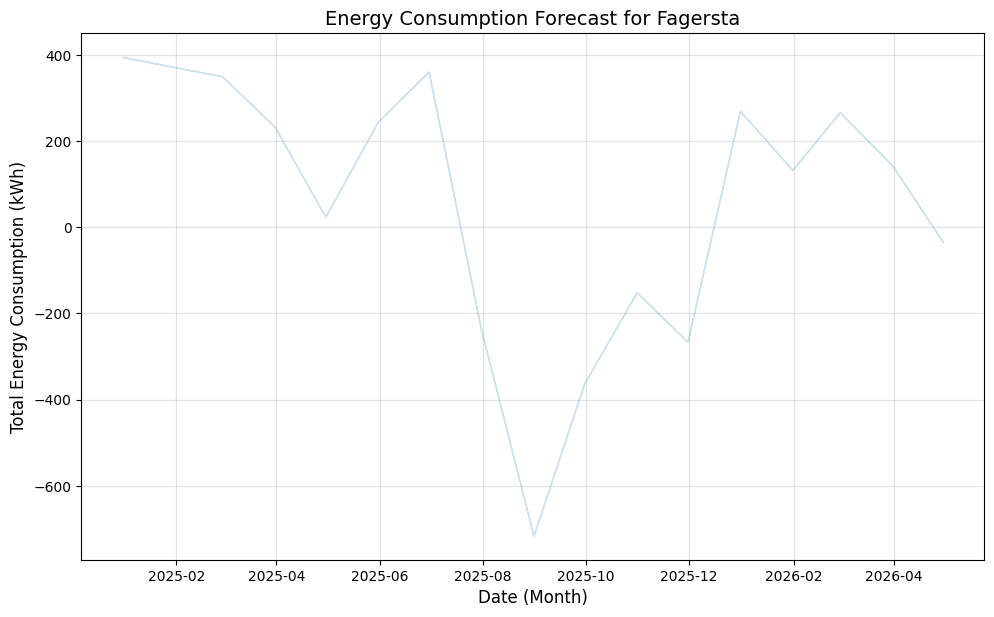

15:11:21 - cmdstanpy - INFO - Chain [1] start processing
15:11:21 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Finspång


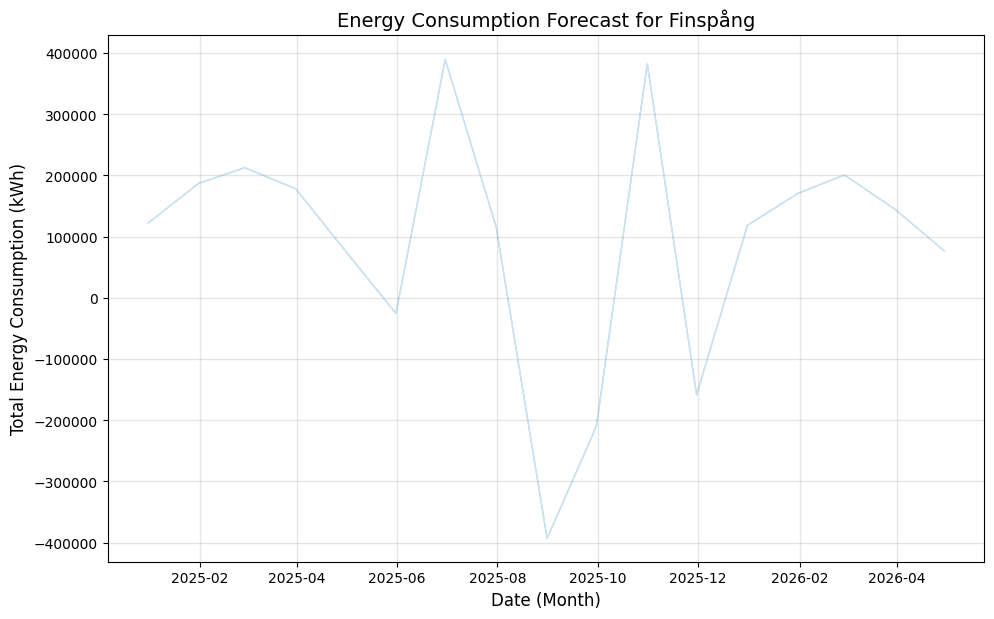

15:11:21 - cmdstanpy - INFO - Chain [1] start processing



Forecasting: Frövi


15:11:22 - cmdstanpy - INFO - Chain [1] done processing


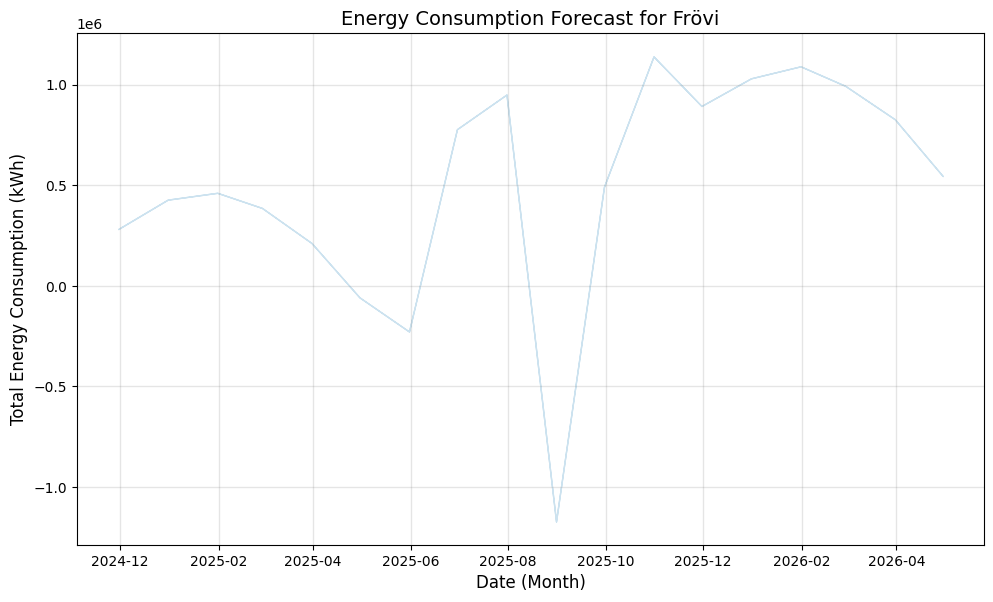

15:11:22 - cmdstanpy - INFO - Chain [1] start processing
15:11:22 - cmdstanpy - INFO - Chain [1] done processing


Skipping Gnesta due to insufficient data (1 rows).

Forecasting: Grums


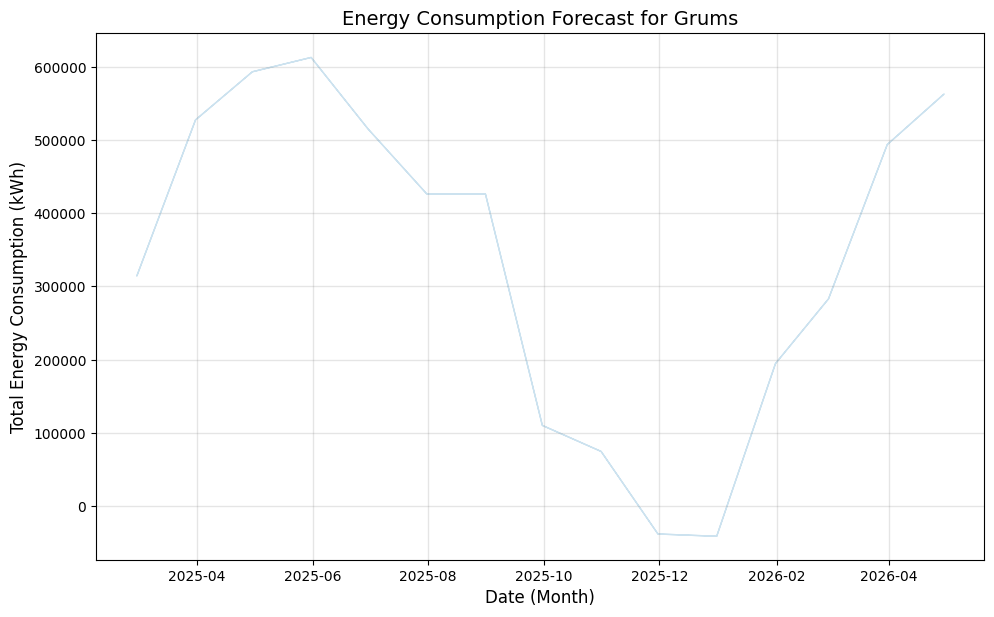

15:11:22 - cmdstanpy - INFO - Chain [1] start processing
15:11:22 - cmdstanpy - INFO - Chain [1] done processing


Skipping Grycksbo due to insufficient data (1 rows).

Forecasting: Göteborg


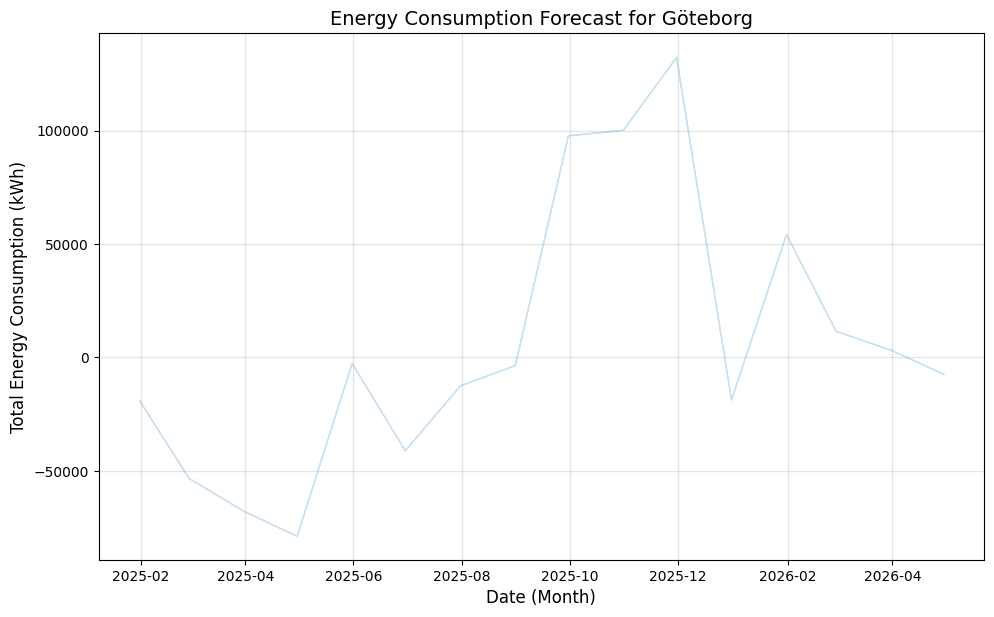

15:11:23 - cmdstanpy - INFO - Chain [1] start processing



Forecasting: Jonsered


15:11:23 - cmdstanpy - INFO - Chain [1] done processing


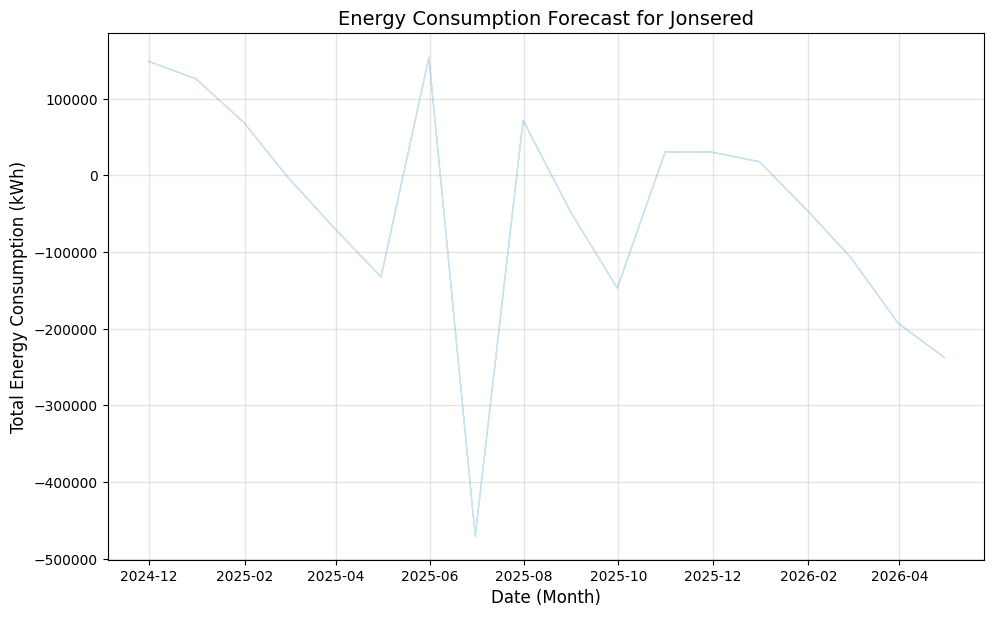

15:11:23 - cmdstanpy - INFO - Chain [1] start processing
15:11:23 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Kisa


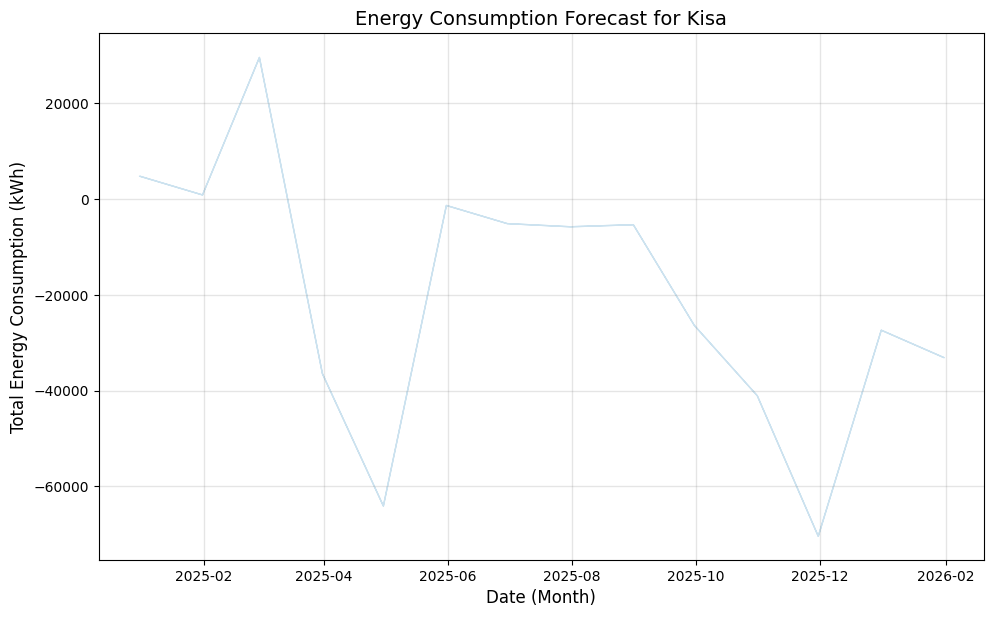

15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Kävlinge


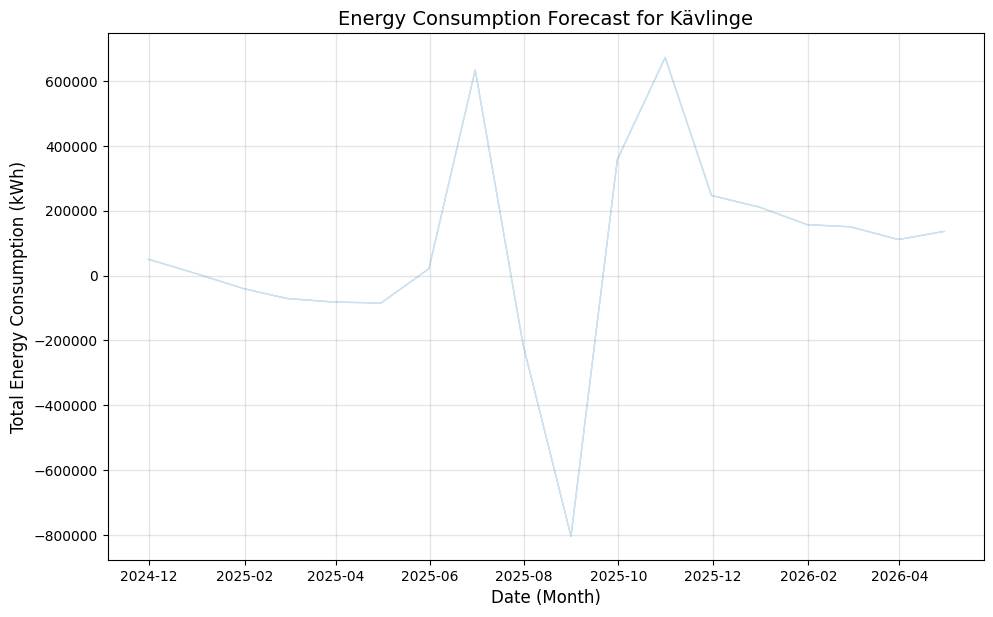

15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Ljungsarp


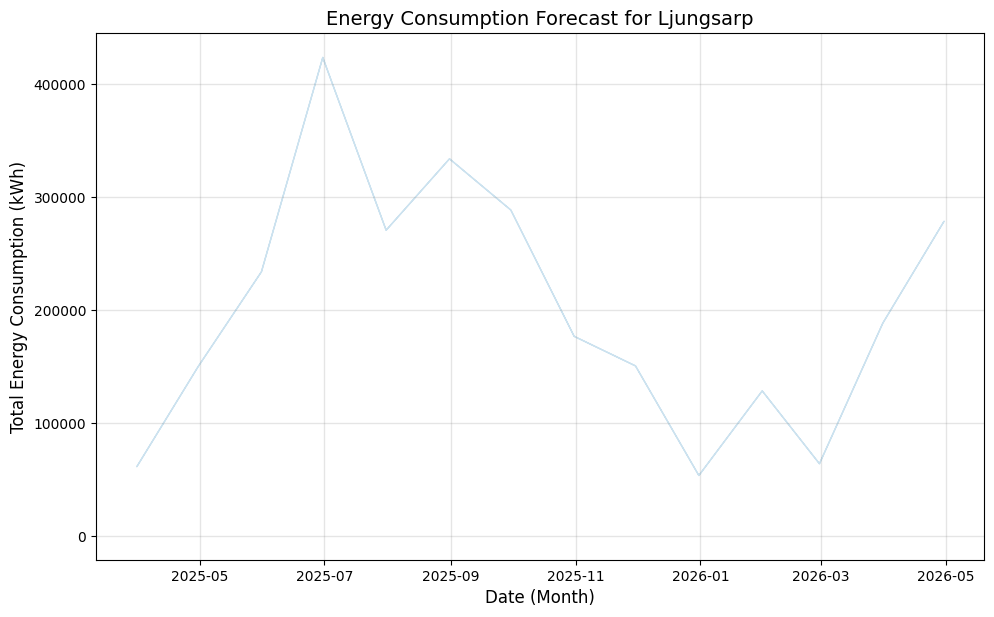

15:11:24 - cmdstanpy - INFO - Chain [1] start processing
15:11:24 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Mora


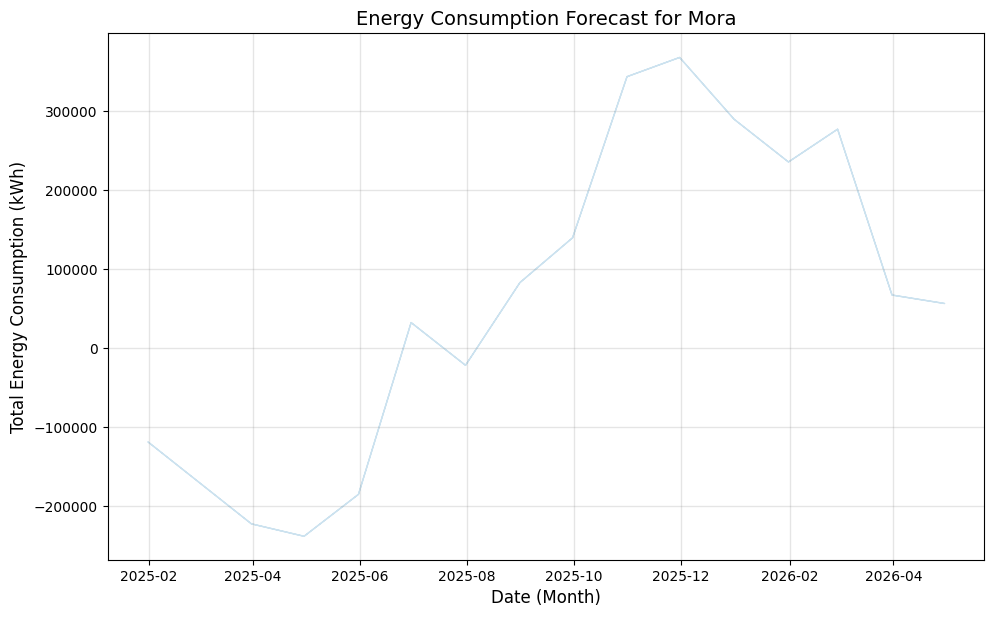

15:11:24 - cmdstanpy - INFO - Chain [1] start processing



Forecasting: Mörlunda


15:11:25 - cmdstanpy - INFO - Chain [1] done processing


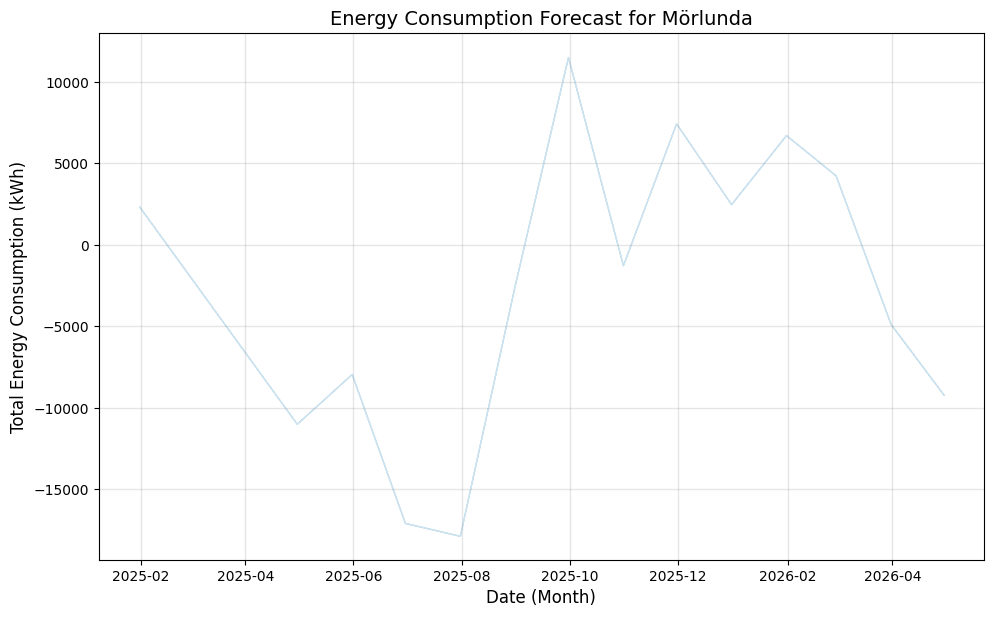

15:11:25 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Norra Sorunda


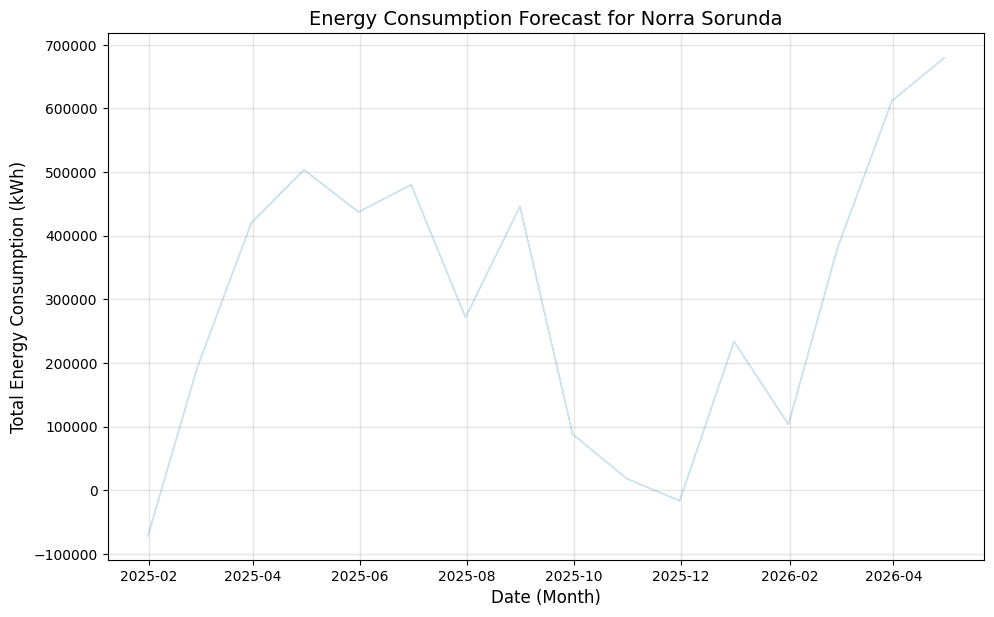

15:11:25 - cmdstanpy - INFO - Chain [1] start processing
15:11:25 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Nyköping


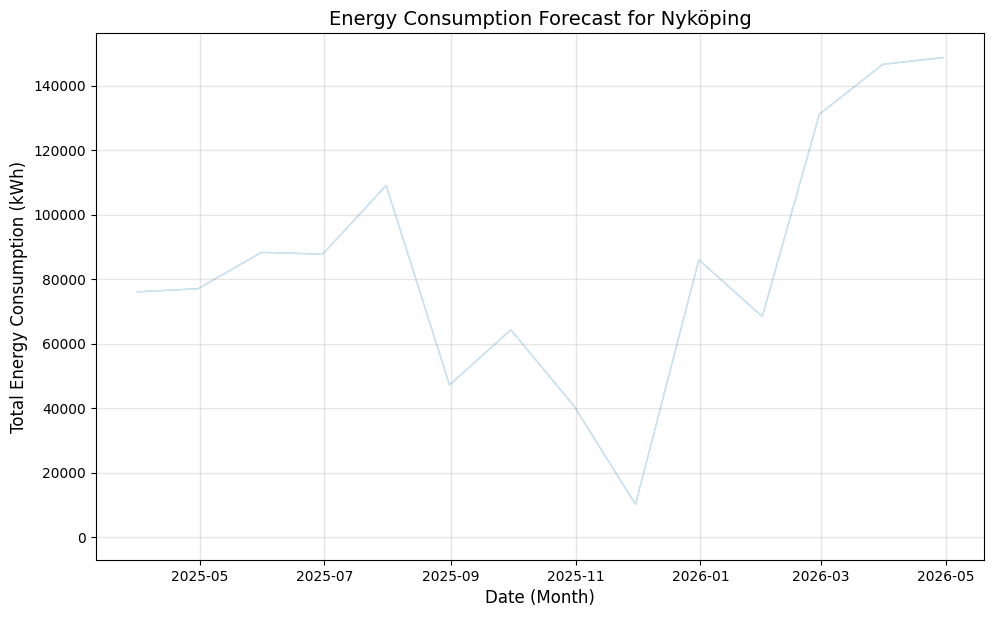

15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:26 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Nässjö


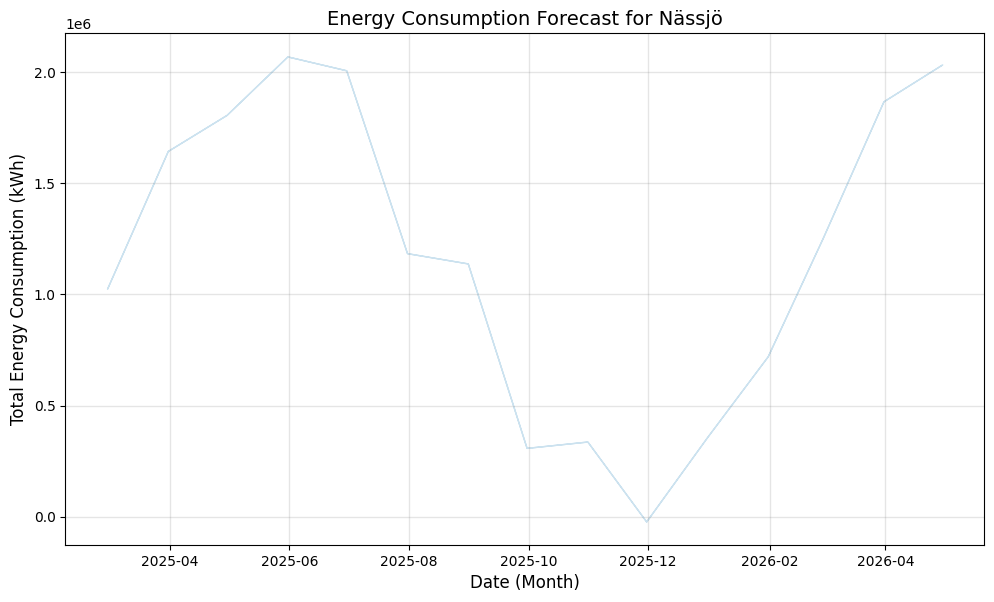

15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:26 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Rydal


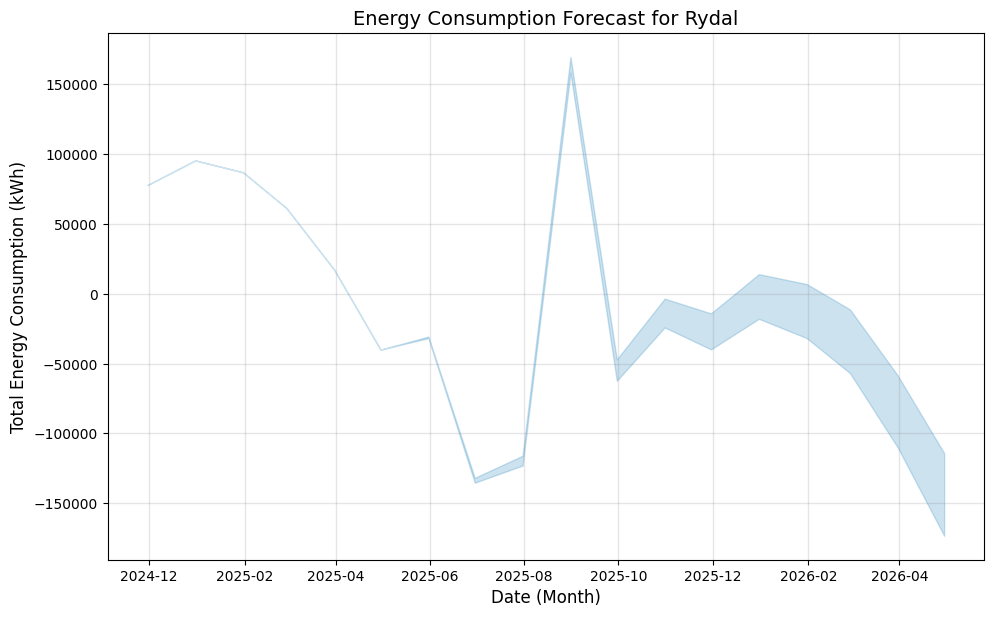

15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:26 - cmdstanpy - INFO - Chain [1] done processing


Skipping Rönninge due to insufficient data (1 rows).

Forecasting: Rönnäng


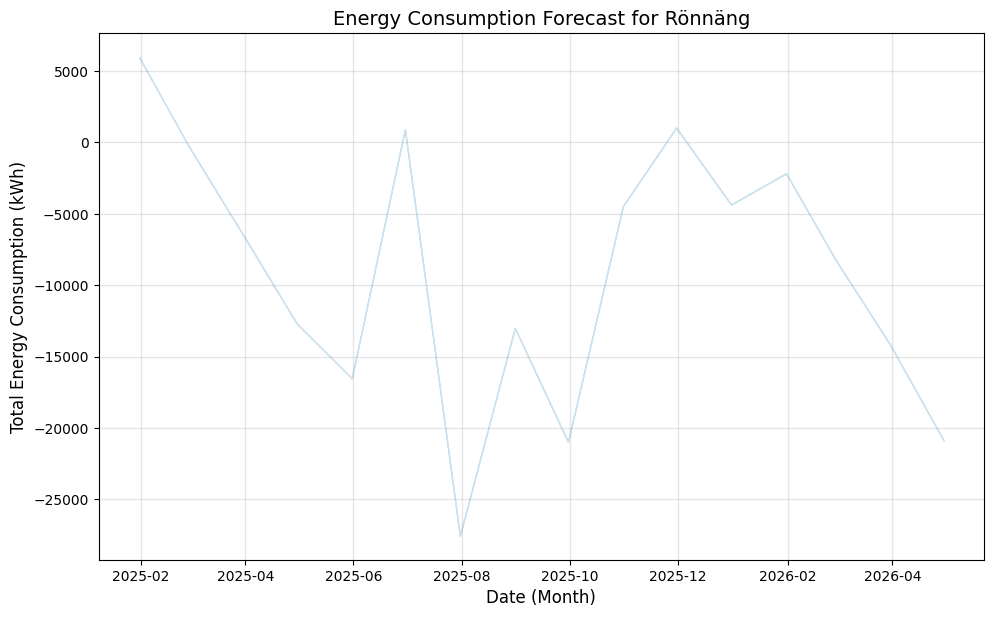

15:11:26 - cmdstanpy - INFO - Chain [1] start processing
15:11:27 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Rörvik


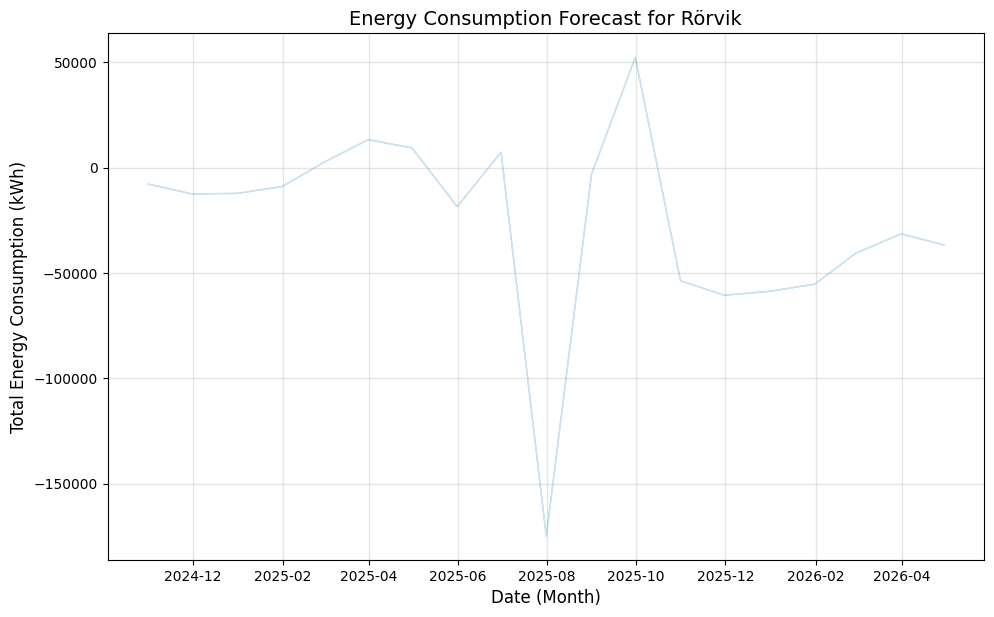

15:11:27 - cmdstanpy - INFO - Chain [1] start processing



Forecasting: Siljansnäs


15:11:31 - cmdstanpy - INFO - Chain [1] done processing


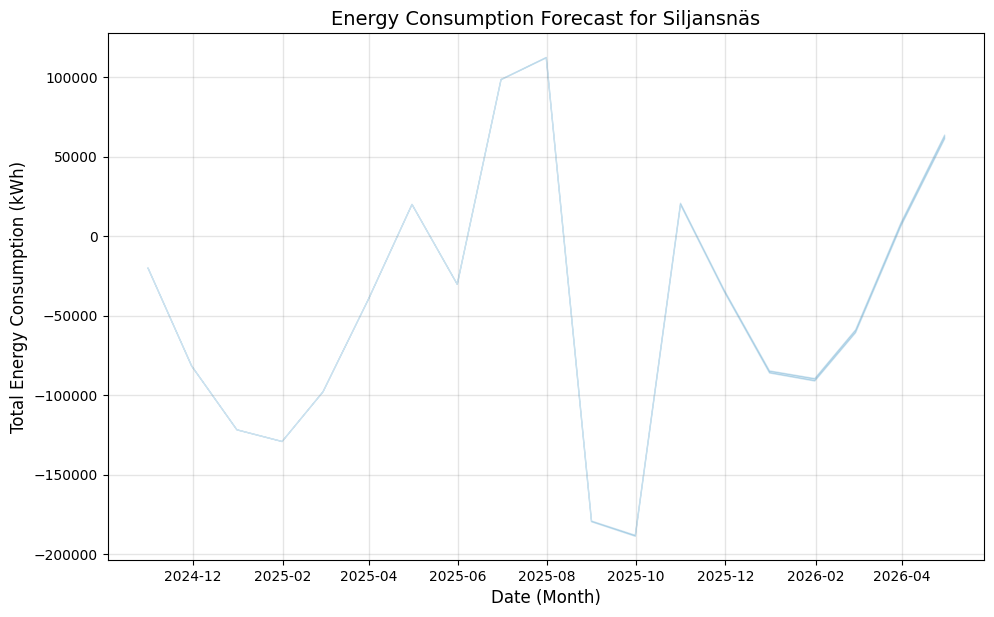

15:11:31 - cmdstanpy - INFO - Chain [1] start processing


Skipping Simrishamn due to insufficient data (1 rows).

Forecasting: Skutskär


15:11:31 - cmdstanpy - INFO - Chain [1] done processing


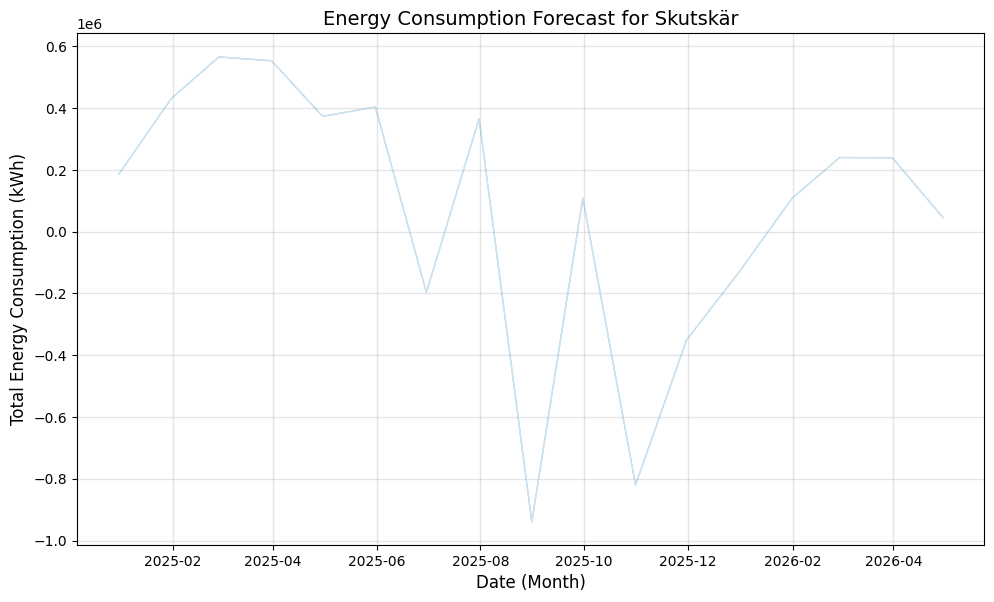

15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Smedjebacken


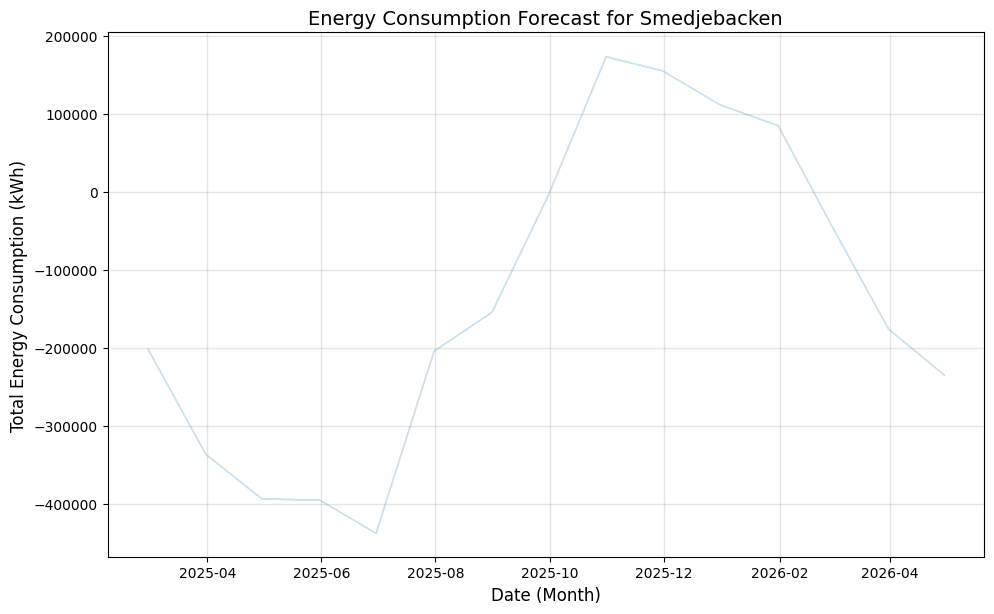

15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Sollebrunn


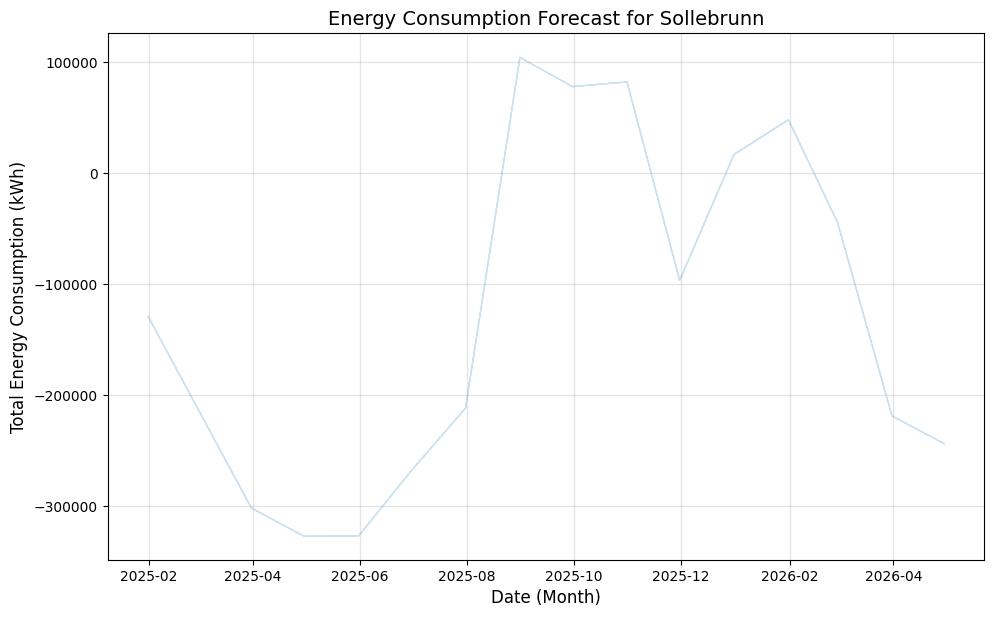

15:11:32 - cmdstanpy - INFO - Chain [1] start processing
15:11:32 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Sågmyra


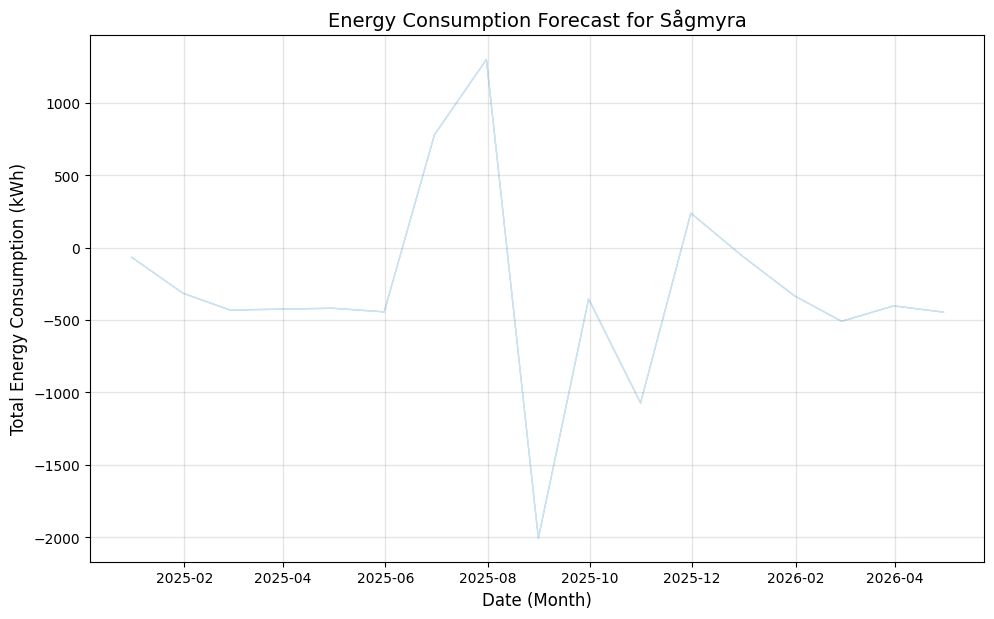

15:11:33 - cmdstanpy - INFO - Chain [1] start processing


Skipping Söderfors due to insufficient data (1 rows).

Forecasting: Södertälje


15:11:33 - cmdstanpy - INFO - Chain [1] done processing


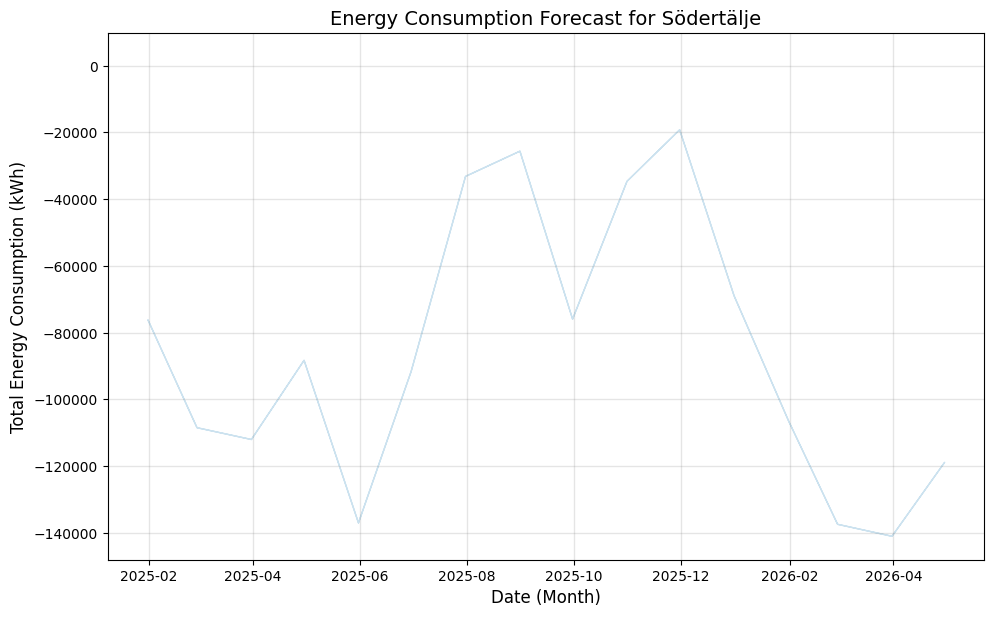

15:11:33 - cmdstanpy - INFO - Chain [1] start processing
15:11:33 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Södra Sandby


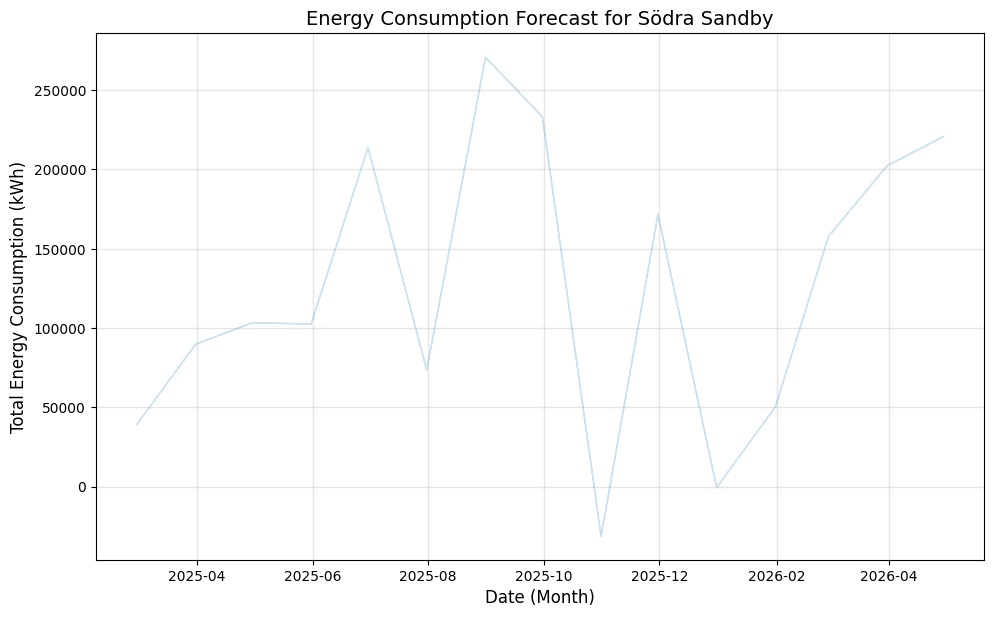

15:11:33 - cmdstanpy - INFO - Chain [1] start processing
15:11:33 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Trångsund


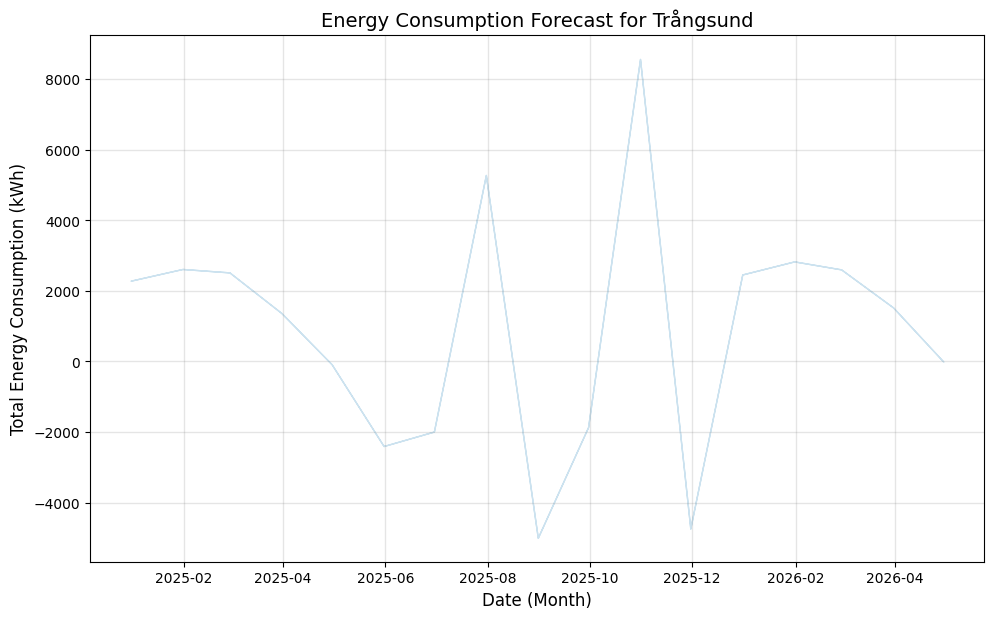

15:11:33 - cmdstanpy - INFO - Chain [1] start processing
15:11:33 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Uppsala


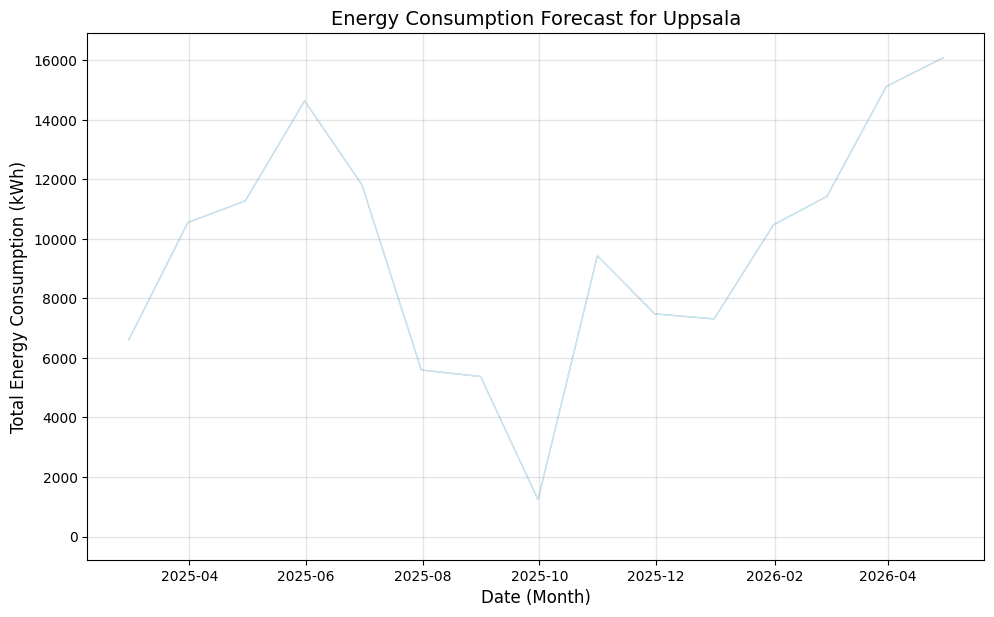

15:11:34 - cmdstanpy - INFO - Chain [1] start processing


Skipping Vallentuna due to insufficient data (1 rows).
Skipping Varberg due to insufficient data (1 rows).
Skipping Vattholma due to insufficient data (1 rows).

Forecasting: Våxtorp


15:11:34 - cmdstanpy - INFO - Chain [1] done processing


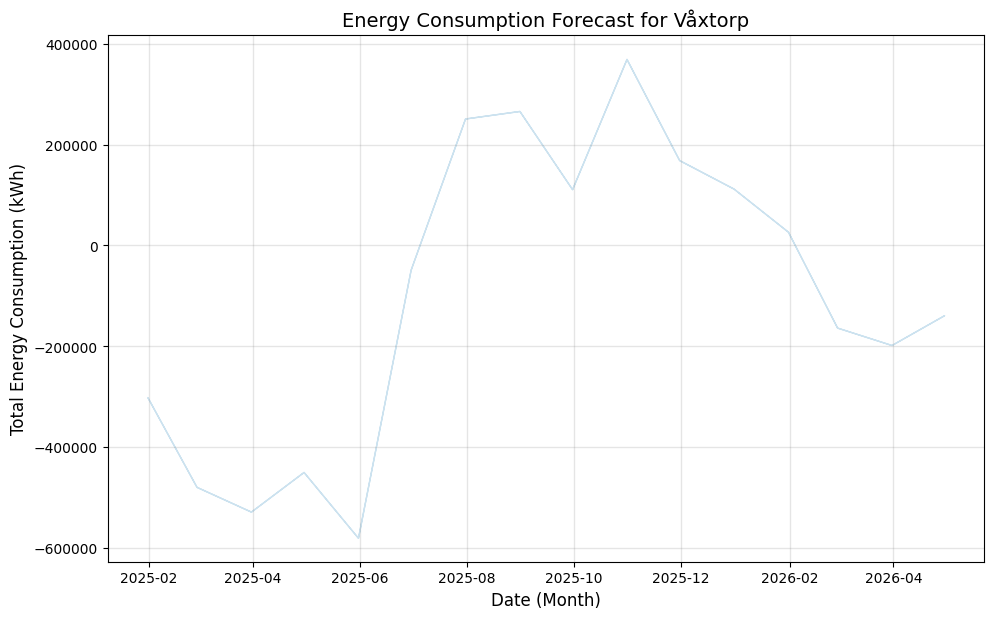

15:11:34 - cmdstanpy - INFO - Chain [1] start processing
15:11:34 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Åhus


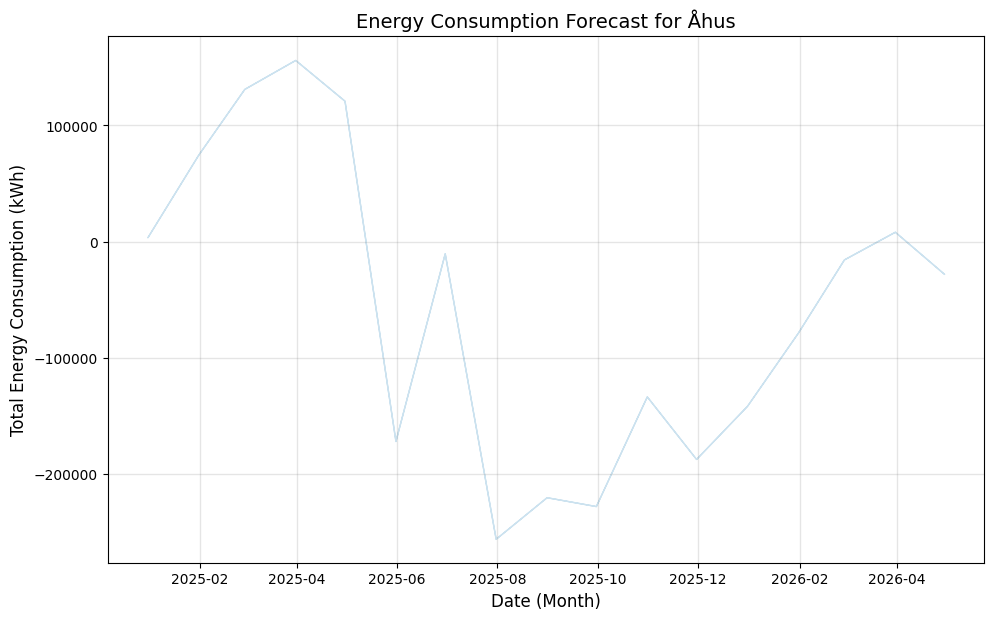

15:11:34 - cmdstanpy - INFO - Chain [1] start processing
15:11:34 - cmdstanpy - INFO - Chain [1] done processing



Forecasting: Åsensbruk


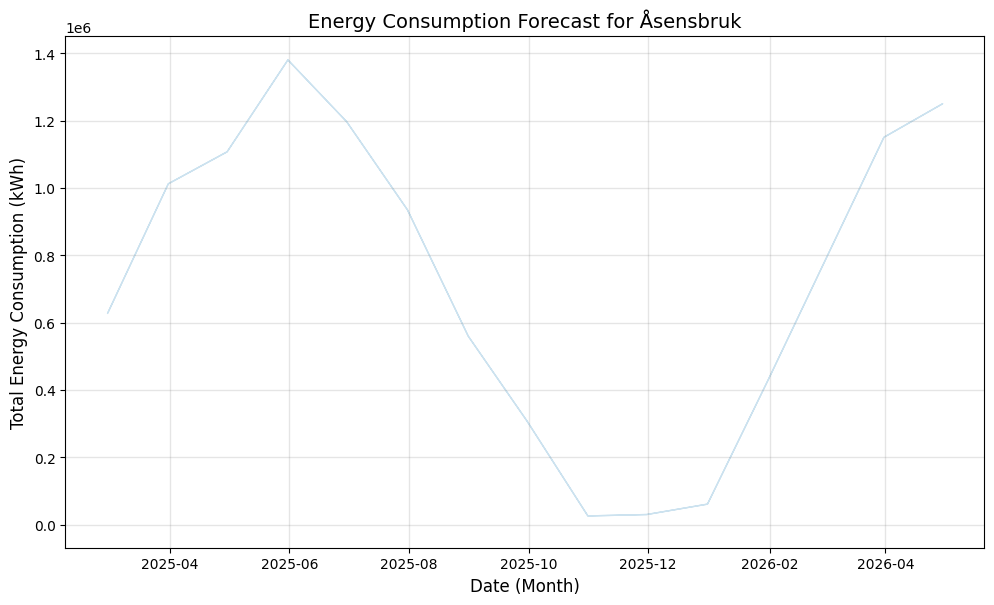

All forecasts saved to individual CSVs and combined CSV.


In [235]:
Towns = monthly_grouped['Town'].unique()
all_forecasts = []

for Town in Towns:
    df_Town = monthly_grouped[monthly_grouped['Town'] == Town]
    
    if len(df_Town) < 2:
        print(f"Skipping {Town} due to insufficient data ({len(df_Town)} rows).")
        continue

    print(f"\nForecasting: {Town}")
    forecast_df = train_and_forecast_Town(monthly_grouped, Town)
    all_forecasts.append(forecast_df)


# Combine all forecasts into one DataFrame
combined_forecast = pd.concat(all_forecasts, ignore_index=True)
combined_forecast.to_csv("all_Towns_forecast.csv", index=False)

print("All forecasts saved to individual CSVs and combined CSV.")

# Forecasting Energy Consumption Using Prophet – Project Summary

## Objective

The goal of this analysis was to forecast monthly energy consumption across multiple Towns in Sweden using historical energy data. Accurate forecasts support better planning for energy infrastructure, resource allocation, and sustainability initiatives.

---

## Modeling Approach: Facebook Prophet

We used **Facebook Prophet**, a robust additive time series model particularly suited for capturing **seasonality**, **trends**, and **holidays** in business and environmental data. Prophet allows for:

- Automatic detection of seasonal patterns
- Modeling of custom regressors (in our case, **month-based cyclical features**)
- Quick interpretability and deployment

---

## Feature Engineering

To inject seasonal awareness into the model, we encoded the **month** feature using sine and cosine transformations:

- `Month_sin = sin(2π * month / 12)`
- `Month_cos = cos(2π * month / 12)`

These features allowed Prophet to learn annual periodicity without manually defining monthly effects.

---

## Forecasting Pipeline

The following key steps were performed:

1. **Group** data by Town and resample monthly.
2. **Train** a separate Prophet model for each Town.
3. Use `make_future_dataframe()` to generate the next 12 months.
4. Predict future consumption and **save** each Town’s model and forecast:
   - Forecasts saved as CSV files with the structure:
     - `Date_Stamp`: The target date
     - `Forecast_kWh`: Predicted consumption
     - `Forecast_Lower_Bound` / `Upper_Bound`: Confidence interval
     - `Town`: For identification
5. **Plot** forecasts with uncertainty bounds to visualize the trend per region.

---

## Key Insights

- **Seasonality was evident**: The model successfully picked up cyclical consumption patterns likely tied to heating needs and daylight variations.
- **Model training was efficient**, and forecasts were generally smooth and consistent with historical trends.
- **Forecasts were saved per-Town**, enabling individual analysis and comparison.

---

## Challenges & Limitations

Despite Prophet's strengths, we observed several domain-specific issues:

1. **Negative Forecast Values**  
   - Some forecasts produced negative energy consumption values — an invalid outcome in real-world energy systems.

      Why Are There Negative Forecasts?

      Prophet is a general-purpose time series model that does not inherently enforce non-negativity constraints. It fits a combination of:

      **Trend**: Which could go negative if the slope and intercept allow it.

      **Seasonality**: Which oscillates (sinusoidal basis), and that too can push predictions downward.

      **Custom Regressors**: If these aren’t scaled or their coefficients aren't constrained, they can exaggerate dips.

      So, if the historical values dip low, or Prophet’s components add up in the wrong way, negative predictions can emerge.

      **Why This Is a Problem**

      From a domain knowledge perspective:

      Energy consumption (kWh) cannot be negative.

      Unless we're modeling net energy, where energy production can exceed usage (e.g., solar panels feeding back into the grid), this is indeed invalid.

      Prophet does not know the domain constraints unless we tell it explicitly.

   - We initially applied a **log-transformation** on the target variable to ensure outputs were strictly positive.
   - However, after inverse-transforming the predictions, we observed **inflated values or zeros**, impacting forecast quality.

2. **Clamping Attempt (Post-hoc Fix)**  
   - We attempted to clamp forecasts to a minimum value (e.g., 1 kWh), but this created **artificial flatlines**, especially in low-demand Towns.

3. **Single-Series Models for Each Town**  
   - Prophet models were trained per-Town, **ignoring inter-series relationships** (e.g., similar Towns likely follow similar seasonal behavior).
   - No cross-series learning meant small Towns with little data often underperformed.

4. **Limited Modeling of Uncertainty**  
   - While Prophet offers prediction intervals, the **realistic variability across Towns and temporal regimes** might be better captured by probabilistic deep learning models.

---

## Conclusion

Prophet served as a **valuable baseline** for forecasting energy consumption. It provided a simple, fast, and interpretable framework to understand the general seasonality and trends across Towns.

limitations in handling:
- multiple correlated time series,
- domain constraints like non-negativity,
- and more complex temporal dependencies,
---
